#### Install required libraries


In [1]:
#! pip install zoish --force-reinstall
#! pip install feature-engine category-encoders scikit-learn ipywidgets numpy pandas  --force-reinstall

In [13]:
# Importing built-in libraries
import pandas as pd  # For data manipulation and analysis
import sys  # For accessing system-specific parameters and functions
import zoish  # Assuming it's a custom library for your project
import sklearn  # For machine learning models
import numpy  # For numerical computations

# Importing scikit-learn utilities for various ML tasks
from sklearn.compose import ColumnTransformer  # For applying transformers to columns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.metrics import (  # For evaluating the model
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, train_test_split  # For CV and splitting dataset
from sklearn.pipeline import Pipeline  # For creating ML pipelines
from sklearn.preprocessing import StandardScaler,FunctionTransformer  # For feature scaling

# Importing other third-party libraries
from category_encoders import TargetEncoder  # For encoding categorical variables
from zoish.feature_selectors.shap_selectors import (  # For feature selection and visualization
    ShapFeatureSelector,
    ShapPlotFeatures,
)
import logging  # For logging events and errors

# Configuring logging settings
from zoish import logger  # Assuming it's a custom logger from zoish
logger.setLevel(logging.ERROR)  # Set logging level to ERROR

# Importing feature imputation library
from feature_engine.imputation import MeanMedianImputer  # For imputing mean/median

# Re-setting logging level (this seems redundant, consider keeping only one)
logger.setLevel(logging.ERROR)

# Printing versions of key libraries for debugging and documentation
print(f'Python version : {sys.version}')
print(f'zoish version : {zoish.__version__}')
print(f'sklearn version : {sklearn.__version__}')
print(f'pandas version : {pd.__version__}')  # Using the alias for pandas
print(f'numpy version : {numpy.__version__}')


Python version : 3.7.17 (default, Aug 31 2023, 09:57:32) 
[Clang 14.0.3 (clang-1403.0.22.14.1)]
zoish version : 5.0.1
sklearn version : 1.0.2
pandas version : 1.3.5
numpy version : 1.21.6


#### Example: Audiology (Standardized) Data Set
###### https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29


#### Read data


In [3]:
urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data"
urlname = "https://archive.ics.uci.edu/ml/machine-learning-databases/lung-cancer/lung-cancer.names"
# column names
col_names = [
    "class",
    "lymphatics",
    "block of affere",
    "bl. of lymph. c",
    "bl. of lymph. s",
    "by pass",
    "extravasates",
    "regeneration of",
    "early uptake in",
    "lym.nodes dimin",
    "lym.nodes enlar",
    "changes in lym.",
    "defect in node",
    "changes in node",
    "special forms",
    "dislocation of",
    "exclusion of no",
    "no. of nodes in",

]

data = pd.read_csv(urldata,names=col_names)
data.head()


,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,special forms,dislocation of,exclusion of no,no. of nodes in
3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


#### Define labels and train-test split


In [4]:


data.loc[(data["class"] == 1) | (data["class"] == 2), "class"] = 0
data.loc[data["class"] == 3, "class"] = 1
data.loc[data["class"] == 4, "class"] = 2
data["class"] = data["class"].astype(int)

#### Train test split


In [5]:
X = data.loc[:, data.columns != "class"]
y = data.loc[:, data.columns == "class"]

y= y['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,  random_state=42
)

#### Defining the feature pipeline steps:
Here, we use an untuned XGBClassifier model with the ShapFeatureSelector.In the next section, we will repeat the same process but with a tuned XGBClassifier. The aim is to demonstrate that a better estimator can yield improved results when used with the ShapFeatureSelector.


In [6]:
estimator_for_feature_selector= LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
estimator_for_feature_selector.fit(X_train, y_train)
shap_feature_selector = ShapFeatureSelector(
    model=estimator_for_feature_selector, 
    num_features=5, 
    cv = 5, 
    scoring='accuracy', 
    direction='maximum', 
    n_iter=10, 
    algorithm='auto',        
    predict_proba_params={},
    faster_kernelexplainer=True,

)
        

# Assuming X_train is a pandas DataFrame

# Define pre-processing for numeric columns (float and integer types)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define pre-processing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(handle_missing='return_nan'))])

# Function to convert the output to a DataFrame
def to_dataframe(X, numeric_features, categorical_features):
    transformed_cols = list(numeric_features) + list(categorical_features)
    return pd.DataFrame(X, columns=transformed_cols)

# Combine preprocessing into one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Feature Selection using ShapSelector 
feature_selection = shap_feature_selector 

# Classifier model
classifier =  LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Include to_dataframe function in pipeline
pipeline = Pipeline(
    steps=[
    ('preprocessor', preprocessor),
    ('to_dataframe', FunctionTransformer(to_dataframe, kw_args={'numeric_features': numeric_features, 'categorical_features': categorical_features})),
    ('feature_selection',shap_feature_selector),
    ('classifier', classifier)
    ]
    )

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])

X does not have valid feature names, but LogisticRegression was fitted with feature names


  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

  0%|          | 0/99 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

[0 0 1 0 0 0 0 0 0 0]


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


#### Check performance of the Pipeline


In [7]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.46938775510204084
Classification report : 
              precision    recall  f1-score   support

           0       0.46      0.81      0.59        21
           1       0.44      0.29      0.35        14
           2       0.67      0.14      0.24        14

    accuracy                           0.47        49
   macro avg       0.52      0.41      0.39        49
weighted avg       0.51      0.47      0.42        49

Confusion matrix : 
[[17  4  0]
 [ 9  4  1]
 [11  1  2]]


#### Shap related plots

feature_selector.importance_df.shape[0] 17
feature_selector.num_features 5


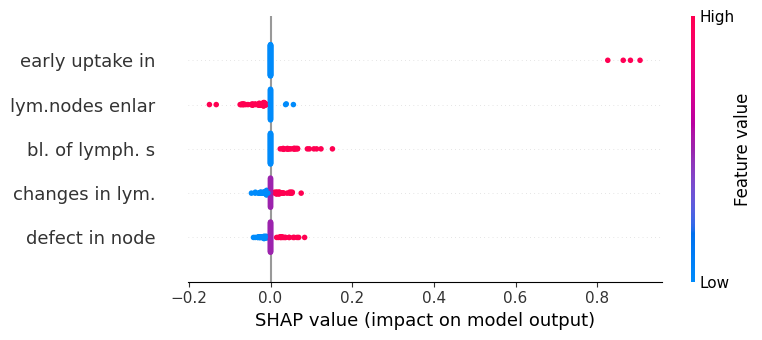

In [8]:

# Plot the feature importance
plot_factory = ShapPlotFeatures(shap_feature_selector) 
plot_factory.summary_plot()


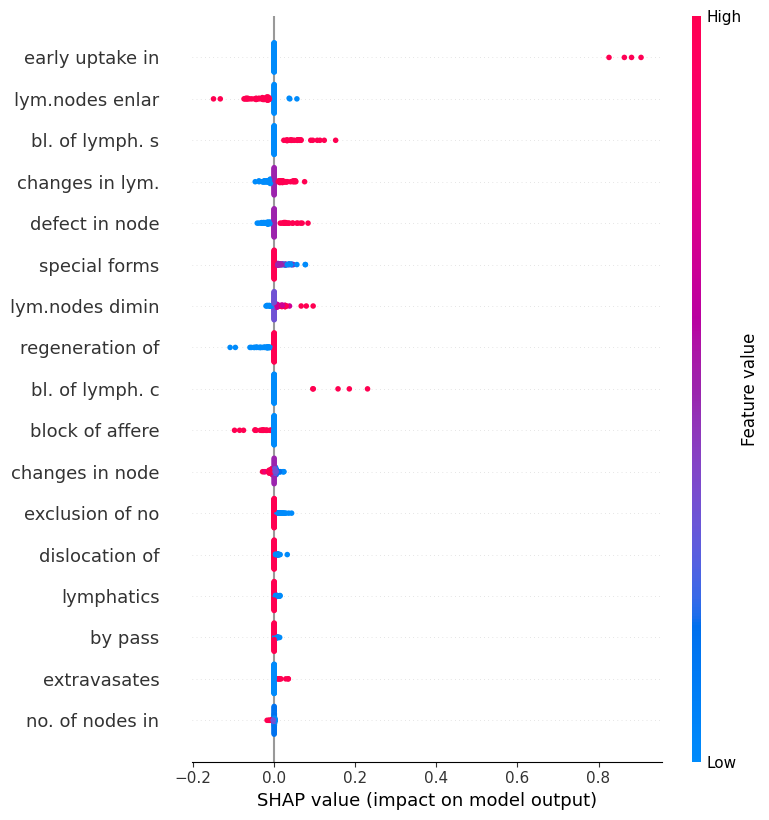

In [9]:
plot_factory.summary_plot_full()

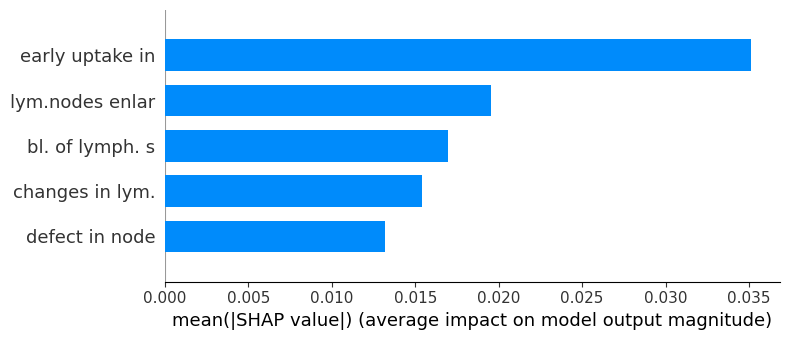

In [10]:

# Plot the feature importance
plot_factory.bar_plot()

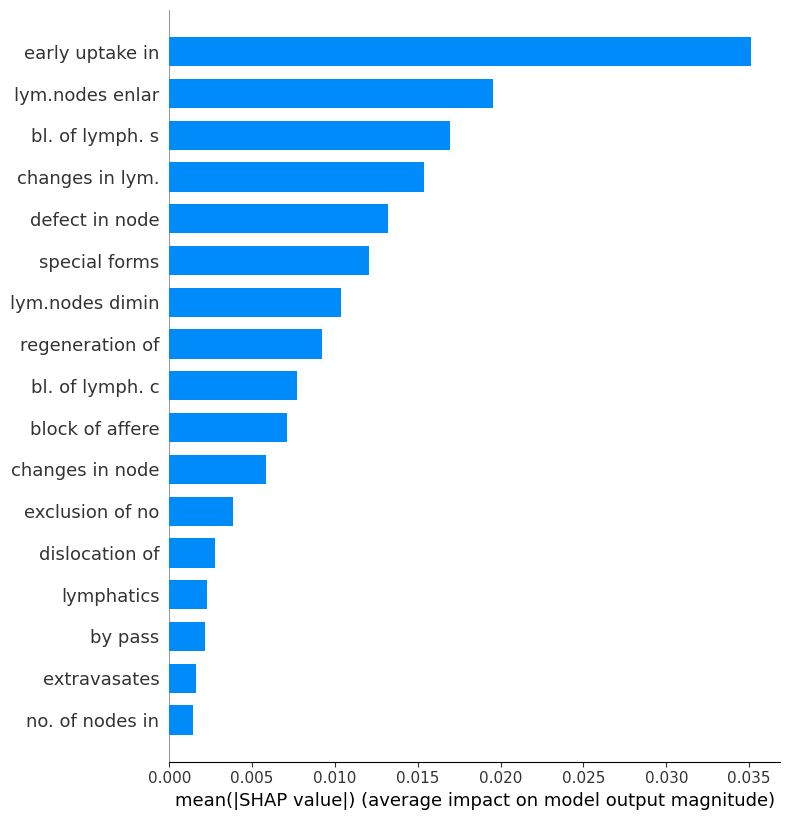

In [11]:
plot_factory.bar_plot_full()

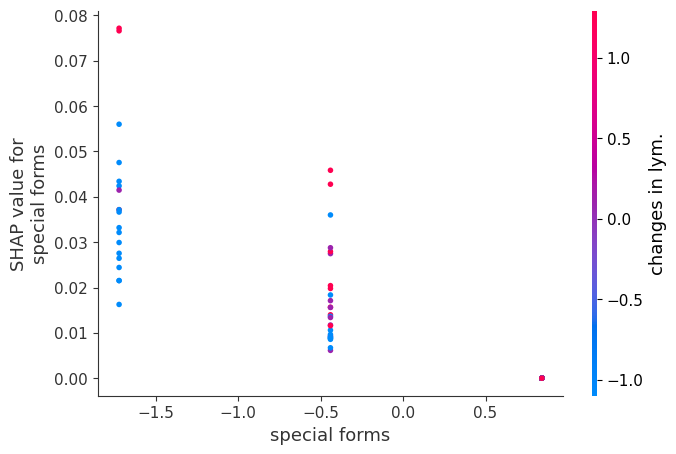

In [12]:
plot_factory.dependence_plot('special forms')